# Lesson 3: Data as a Random Variable
## Intro to Quantified Cognition
By: Per B. Sederberg, PhD

<a href="https://colab.research.google.com/github/compmem/QuantCog/blob/2022_Fall/notebooks/03_Data_As_A_Random_Variable.ipynb"><img align="left" src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open in Colab" title="Open and Execute in Google Colaboratory"></a>

## Lesson Plan

- Introduce data as a random variable
- Probability distributions as models of the world
- Statistics as performing inference on those models
- Assessing model fit
- Model comparison
- A real(ish) example!

## Data as a random variables

Most statistics operates under the assumption that any observed data are actual samples drawn from some (to be learned) model of the world.

In the standard approach, these models are simply probability distributions, with parameters that govern the behavior of the model (i.e., what we can expect they will produce).

## Uncertainty

If the observed data samples are simply random draws from a probability distribution, then the level of uncertainty will decrease as we gain more data samples.

Statistical inference involves figuring out what model (e.g., probability distribution, but we will be building more complicated models later in the course) and parameters generated the data. 

Let's spend some time trying to perform this task by hand...

## *ONLY* if on Google Colab


In [157]:
# to retrieve the dists.py and data files
!wget https://raw.githubusercontent.com/compmem/QuantCog/2022_Fall/notebooks/dists.py
!wget https://raw.githubusercontent.com/compmem/QuantCog/2022_Fall/notebooks/random_data.pickle

--2020-02-06 15:37:12--  https://raw.githubusercontent.com/compmem/QuantCog/2020_Spring/notebooks/dists.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 199.232.64.133
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|199.232.64.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1077 (1.1K) [text/plain]
Saving to: ‘dists.py.1’

dists.py.1          100%[===================>]   1.05K  --.-KB/s    in 0s      

2020-02-06 15:37:13 (59.0 MB/s) - ‘dists.py.1’ saved [1077/1077]

--2020-02-06 15:37:13--  https://raw.githubusercontent.com/compmem/QuantCog/2020_Spring/notebooks/random_data.pickle
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 199.232.64.133
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|199.232.64.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1942 (1.9K) [application/octet-stream]
Saving to: ‘random_data.pickle.1’

random_data.pickle. 100%[==

## Load necessary libraries

In [1]:
# load matplotlib inline mode
%matplotlib inline

# import some useful libraries
import numpy as np                # numerical analysis linear algebra
import pandas as pd               # efficient tables
import matplotlib.pyplot as plt   # plotting
import ipywidgets as widgets      # interactive widgets
from ipywidgets.widgets.interaction import show_inline_matplotlib_plots
from IPython.display import display, clear_output
import pickle

# import the distributions wrapped from scipy
import dists

In [2]:
# load in the data
with open('random_data.pickle', 'rb') as f:
    data = pickle.load(f)

# tell us something about the data
for i,d in enumerate(data):
    print('Dataset %d has %d samples' % (i, len(d)))

Dataset 0 has 10 samples
Dataset 1 has 10 samples
Dataset 2 has 25 samples
Dataset 3 has 25 samples
Dataset 4 has 25 samples
Dataset 5 has 50 samples
Dataset 6 has 50 samples


In [3]:
# mapper between dist name and object
dist_dict = {'Beta': dists.beta,
             'Exponential': dists.exp,
             'Gamma': dists.gamma,
             'Normal': dists.normal,
             'Uniform': dists.uniform}

# Dropdown widget to pick datasets
ds_ind = widgets.Dropdown(options=range(len(data)),
                          description="Dataset")

# Checkbox for whether to show log likelihood
like_check = widgets.Checkbox(description='Show Log Likelihood', 
                              value=False)

# Checkbox for whether to show stem plot
stem_check = widgets.Checkbox(description='Show Stem Plot', 
                              value=False)

# set up the parameters
children = []

# beta params
beta_button = widgets.Button(description='Beta', icon='check')
beta_alpha = widgets.FloatText(value=.5,
                               description='alpha')
beta_beta = widgets.FloatText(value=.5,
                              description='beta')
children.append(widgets.HBox([beta_button, beta_alpha, beta_beta]))

# exp params
exp_button = widgets.Button(description='Exponential', icon='')
exp_lam = widgets.FloatText(value=5.0,
                            description='lam')
children.append(widgets.HBox([exp_button, exp_lam]))

# gamma params
gamma_button = widgets.Button(description='Gamma', icon='')
gamma_alpha = widgets.FloatText(value=.5,
                                description='alpha')
gamma_beta = widgets.FloatText(value=.5,
                              description='beta')
children.append(widgets.HBox([gamma_button, gamma_alpha, gamma_beta]))

# normal params
normal_button = widgets.Button(description='Normal', icon='')
normal_mean = widgets.FloatText(value=0.0,
                                description='mean')
normal_std = widgets.FloatText(value=1.0,
                               description='std')
children.append(widgets.HBox([normal_button, normal_mean, normal_std]))

# uniform params
uniform_button = widgets.Button(description='Uniform', icon='')
uniform_lower = widgets.FloatText(value=0.0,
                                  description='lower')
uniform_upper = widgets.FloatText(value=1.0,
                                  description='upper')
children.append(widgets.HBox([uniform_button, uniform_lower, uniform_upper]))


# set the full user interface
ui = widgets.VBox([widgets.HBox([ds_ind, like_check, stem_check])]+children)


# define plotting function
def plot_data_and_dist(*vals, **kwargs):
    # first plot the data
    dat = data[ds_ind.value]
    plt.hist(dat, bins='auto', density=True, alpha=.5);
    
    # now plot the pdf of the dist
    npoints = 100
    
    # add support for 10% of the data range on either side
    support = (dat.min() - np.ptp(dat)*.1,
               dat.max() + np.ptp(dat)*.1)
    x = np.linspace(support[0], support[1], npoints)
    
    # get the selected dist and params
    selected_index = [c.children[0].icon=='check' for c in children].index(True)
    params = {c.description: c.value for c in children[selected_index].children[1:]}
    #params = {c.description: c.value for c in 
    #          dist_tab.children[dist_tab.selected_index].children}
    dist = dist_dict[children[selected_index].children[0].description](**params)
    
    # calculate the pdf
    pdf = dist.pdf(x)
            
    # plot the pdf and add labels
    plt.plot(x, pdf, lw=3)
    plt.xlabel('Value')
    plt.ylabel('Probability Density')
    if like_check.value:
        # calculate the log like
        log_like = np.log(dist.pdf(dat)).sum()

        # add it to the plot with some formatting
        plt.title('Log Like: {:3.4f}'.format(log_like))
    
    if stem_check.value:
        # include the stem plot
        plt.stem(dat, dist.pdf(dat), 'g')

        
# set up triggers for updating the plot
out = widgets.interactive_output(plot_data_and_dist, 
                                 {'ds_ind': ds_ind,
                                  'like_check': like_check,
                                  'stem_check': stem_check,
                                  'beta_alpha': beta_alpha,
                                  'beta_beta': beta_beta,
                                  'exp_lam': exp_lam,
                                  'gamma_alpha': gamma_alpha,
                                  'gamma_beta': gamma_beta,
                                  'normal_mean': normal_mean,
                                  'normal_std': normal_std,
                                  'uniform_lower': uniform_lower,
                                  'uniform_upper': uniform_upper,
                                 })


# handle button presses
def on_button_press(b):
    # make sure that button is checked
    for c in children:
        if c.children[0] == b:
            c.children[0].icon = 'check'
        else:
            c.children[0].icon = ''
    
    # call the plot function
    plot_controls = {'ds_ind': ds_ind,
                   'like_check': like_check,
                   'stem_check': stem_check,
                   'beta_alpha': beta_alpha,
                   'beta_beta': beta_beta,
                   'exp_lam': exp_lam,
                   'gamma_alpha': gamma_alpha,
                   'gamma_beta': gamma_beta,
                   'normal_mean': normal_mean,
                   'normal_std': normal_std,
                   'uniform_lower': uniform_lower,
                   'uniform_upper': uniform_upper,
                  }
    kwargs = {k:v.value for k,v in plot_controls.items()}
    show_inline_matplotlib_plots()
    with out:
        clear_output(wait=True)
        plot_data_and_dist(**kwargs)
        show_inline_matplotlib_plots()
for c in children:
    c.children[0].on_click(on_button_press)

In [4]:
# show everything
display(ui, out)

Output(outputs=({'output_type': 'display_data', 'data': {'text/plain': '<Figure size 432x288 with 1 Axes>', 'i…

## Likelihood calculation

We don't have to do this by eye. Because our model is a probability density function (PDF), we can calculate the likelihood of the data given the model and parameters.

For any given model and parameters, you can determine the likelihood of having observed any individual data point by evaluating the PDF at the value of that data point (*Turn on the Stem Plot.*)


## Maximum Likelihood Estimation

The goal then becomes to maximize the likelihood of observing the data given a model and parameters:

$$P(D \mid \theta, M)$$

As long as the data points are all independent, the likelihood of observing all of them is the product of all the probabilities.

It is more efficient and computationally tractable to perform this in log-space, so we typically convert the likelihood into a sum of log likelihoods.

*Let's turn on the Log Likelihood checkbox above and see if we can do better!*

## Automated optimization

Many approaches have been developed for searching parameter spaces to find the parameters that generate the maximum or minimum value of a function.

## Nelder--Mead Simplex

One very popular algorithm is the Nelder--Mead simplex.

It involves growing and shrinking a simplex (a generalization of a triangle to multiple dimensions) to search the parameter space efficiently to minimize a function.

![](https://upload.wikimedia.org/wikipedia/commons/thumb/d/de/Nelder-Mead_Himmelblau.gif/640px-Nelder-Mead_Himmelblau.gif)

In [5]:
# scipy includes lots of optimization methods
import scipy.optimize as opt

In [6]:
# Define a likelihood function
def like_fun(params, *args):
    # pull the model and dat out of the args
    model = args[0]
    dat = args[1]
    
    # instantiate the model with the params
    dist = model(*params)
    
    # calc the log like
    log_like = np.log(dist.pdf(dat)).sum()
    if np.isnan(log_like):
        log_like = -np.inf
    
    # return the negative of it to minimize
    return -log_like

## Calculate the best-fitting params

In [7]:
# grab the distribution and data from the UI above
dist_name = "Gamma"   # MODIFY THIS (one of the models defined above)
ind = 5                 # MODIFY THIS, TOO (numeric index of the data)

# set the bounds for the distribution
bound_dict = {'Beta': [(0, 10), (0, 10)],
              'Exponential': [(0, 20)],
              'Gamma': [(0, 10), (0, 10)],
              'Normal': [(-10, 10), (0, 10)],
              'Uniform': [(-10, 5), (-5, 10)]}
bounds = bound_dict[dist_name]

# set the model and data
model = dist_dict[dist_name]
dat = data[ind]

# generate a random starting point based on the bounds
# NB: it's possible to generate invalid starting points
x0 = [dists.uniform(*b).rvs() for b in bounds]

# print some information about the distribution and starting values
print('Dataset:', ind)
print('Distribution:', dist_name)
print('Starting value:', x0)
print()

# run the optimizer
# NOTE, not all methods make use of the bounds method
res = opt.minimize(like_fun, x0, args=(model, dat), 
                   #bounds=bounds,
                   #method='L-BFGS-B',
                   #method='BFGS',
                   method='Nelder-Mead',
                   #method='TNC'
                  )
print(res)

Dataset: 5
Distribution: Gamma
Starting value: [5.253867892515261, 3.3794999686030467]

 final_simplex: (array([[2.94679935, 9.25548276],
       [2.94677012, 9.25543827],
       [2.94678273, 9.2554122 ]]), array([-19.44708835, -19.44708835, -19.44708835]))
           fun: -19.447088347972112
       message: 'Optimization terminated successfully.'
          nfev: 128
           nit: 67
        status: 0
       success: True
             x: array([2.94679935, 9.25548276])


## Visualize the fit

/home/per/Nextcloud/class/QuantCog/notebooks/dists.py:161: RuntimeWarning: divide by zero encountered in true_divide
  return dists.gamma(alpha, scale=1. / beta)
/home/per/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:1844: RuntimeWarning: invalid value encountered in true_divide
  place(output, cond, self._pdf(*goodargs) / scale)
<ipython-input-8-15eb81f8458a>:7: RuntimeWarning: divide by zero encountered in log
  z = np.log(model(xx, yy).pdf(dat[:, np.newaxis, np.newaxis])).sum(0)


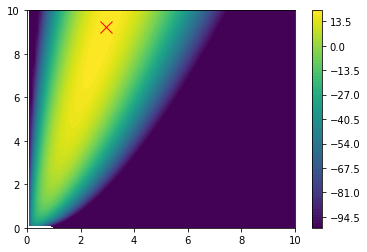

In [8]:
# set the grid of points to evaluate
x = np.linspace(bounds[0][0], bounds[0][1], 100)
y = np.linspace(bounds[1][0], bounds[1][1], 100)
xx, yy = np.meshgrid(x, y, sparse=True)

# evaluate the log likelihood
z = np.log(model(xx, yy).pdf(dat[:, np.newaxis, np.newaxis])).sum(0)
z[z<-100] = -100

# plot the contour and the best-fit value
plt.contourf(x, y, z, 100)
plt.plot(res.x[0], res.x[1], 'x', markersize=12, color='red')
plt.colorbar()
#plt.xlabel()
#plt.ylabel()

## Assessing model fit

We could simply compare the maximum likelihoods between the models, but that doesn't take into account the complexity of each model and amount of data. 

One, more principled, approach is Bayesian Information Criterion (BIC):

$$BIC = \text{ln}(n)k - 2\text{ln}(\hat{L}),$$

where $n$ is the number of data points, $k$ is the number of parameters, and $\hat{L}$ is the maximum likelihood value of the model $M$:

$$\hat{L} = P(x \mid \hat{\theta}, M),$$

where $\hat{\theta}$ are the parameters that maximize the model's likelihood function and $x$ are the observed data.

***SMALLER BIC values are better!!!***

$$BIC = \text{ln}(n)k - 2\text{ln}(\hat{L}),$$

In [89]:
# Calculate the model fit with BIC
# recall that the optimization returns the negative log likelihood
n = len(dat)
k = len(res.x)
L = -res.fun
bic = np.log(n)*k - 2*(L)
print('BIC:', bic)

BIC: -33.92979321674017


In [91]:
# Calculate the model fit with BIC
# recall that the optimization returns the negative log likelihood
n = len(dat)
k = len(res.x)
L = -res.fun
bic = np.log(n)*k - 2*(L)
print('BIC:', bic)

BIC: -31.0701306858576


## Model Comparison

But how do we decide if one model is better than the other? We can compare BIC values between models, turning them into a Bayes Factor!

$$BF_{01} = exp((BIC_1 - BIC_0)/2)$$

This is interpreted with the help of the following guidelines:

| Bayes Factor | Evidence |
|--------------|----------|
| 1--3         | Weak     |
| 3--20        | Positive |
| 20--150      | Strong   |
| >150         | Very Strong | 


In [9]:
# calc Bayes Factor
# (enter numbers from the BIC assessments above)
bic_1 = -31.0701306858576
bic_0 = -33.92979321674017
np.exp((bic_1 - bic_0)/2.)

4.1779941604423625

## t-test example

We now have all the tools necessary to perform statistical inference (though we will improve on all these approaches in the coming weeks). You can:

- Use optimization techniques to identify the parameters that give rise to the maximum likelihood of observing the data given the model
- Assess model fit
- Compare models to guide model selection

Let's try a simple example of performing a t-test via model comparison approaches!

In [11]:
# function to help plot a PDF
def plot_pdf(dist, support=[-5, 5], npoints=100):
    # set a range of linearly-spaced points
    x = np.linspace(support[0], support[1], npoints)
    
    # evaluate the pdf at those points
    pdf = dist.pdf(x)
    
    # plot the results
    plt.plot(x, pdf, lw=3)
    plt.xlabel('Value')
    plt.ylabel('Probability')

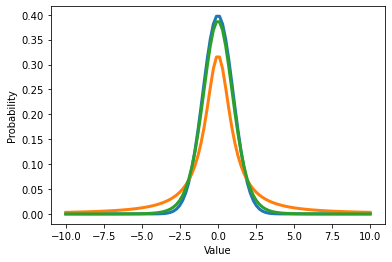

In [12]:
# visualize the student's T distribution
plot_pdf(dists.normal(mean=0.0, std=1.0), support=[-10, 10])
plot_pdf(dists.students_t(mean=0.0, std=1.0, df=1.0), support=[-10, 10])
plot_pdf(dists.students_t(mean=0.0, std=1.0, df=9), support=[-10, 10])


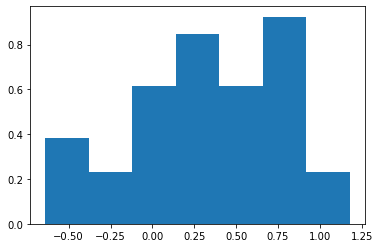

In [13]:
# generate some data that may or may not be significantly different from zero
A = dists.normal(.3, .5).rvs(50)

# plot it
plt.hist(A, bins='auto', density=True);

## Standard t-test

First we'll perform a standard one-sample t-test on our data.

In [14]:
# do a one-sample t-test
import scipy.stats as stats

stats.ttest_1samp(A, 0.0)

Ttest_1sampResult(statistic=5.273543482528924, pvalue=3.0084242149435784e-06)

## Fit a Student's t model

Next we fit the full model to the data.

In [15]:
# Define a likelihood function
def students_like(params, *args):
    # pull the model and dat out of the args
    dat = args[0]
    df = len(dat) - 1
    
    # instantiate the model with the params, 
    # the df is determined from the data
    dist = dists.students_t(params[0], params[1], df)
    
    # calc the log like
    log_like = np.log(dist.pdf(dat)).sum()
    if np.isnan(log_like):
        log_like = -np.inf
    
    # return the negative of it to minimize
    return -log_like

# pick an central starting point
x0 = [0.0, 1.0]

# run the optimization
res = opt.minimize(students_like, x0, args=(A,), 
                   #bounds=bounds,
                   #method='L-BFGS-B',
                   #method='BFGS',
                   method='Nelder-Mead',
                   #method='TNC'
                  )
print(res)

# calculate the BIC for this model and save it
n = len(A)
k = len(res.x)
L = -res.fun
bic_1 = np.log(n)*k - 2*(L)
print('BIC:', bic_1)

 final_simplex: (array([[0.33659109, 0.4362858 ],
       [0.33668543, 0.43621449],
       [0.33653175, 0.43620126]]), array([30.34808005, 30.3480804 , 30.34808088]))
           fun: 30.348080047127276
       message: 'Optimization terminated successfully.'
          nfev: 111
           nit: 59
        status: 0
       success: True
             x: array([0.33659109, 0.4362858 ])
BIC: 68.52020610511084


## Fit a null hypothesis model

Now we fit a model representing the null hypothesis that the mean of the data is actually 0.0. 

Note how we simply fix the mean of the Student's t distribution to zero, but still fit the standard deviation.

In [16]:
# Define a likelihood function
def students_null_like(params, *args):
    # pull the model and dat out of the args
    dat = args[0]
    df = len(dat) - 1
    
    # instantiate the model with the params
    # mean is fixed at zero and the df is determined from the data
    dist = dists.students_t(0.0, params[0], df)
    
    # calc the log like
    log_like = np.log(dist.pdf(dat)).sum()
    if np.isnan(log_like):
        log_like = -np.inf
    
    # return the negative of it to minimize
    return -log_like

# start at same point (though mean is fixed at zero)
x0 = [1.0]

# run the optimization
res = opt.minimize(students_null_like, x0, args=(A,), 
                   #bounds=bounds,
                   #method='L-BFGS-B',
                   #method='BFGS',
                   method='Nelder-Mead',
                   #method='TNC'
                  )
print(res)

# calculate and print the BIC
n = len(A)
k = len(res.x)
L = -res.fun
bic_0 = np.log(n)*k - 2*(L)
print('BIC:', bic_0)

 final_simplex: (array([[0.54824219],
       [0.54833984]]), array([41.67990339, 41.6799042 ]))
           fun: 41.67990338659521
       message: 'Optimization terminated successfully.'
          nfev: 30
           nit: 15
        status: 0
       success: True
             x: array([0.54824219])
BIC: 87.27182977861855


## Model Comparison

Now that we have the BIC values for each model, we can use the Bayes Factor to determine whether the full model is preferred to the null model. 

We want a big number here. If it's less than 1.0 then there is no evidence that the alternative/full model should be preferred to the null model (i.e., the mean of the distribution is not different from 0.0).

In [18]:
# calculate Bayes Factor favoring full model
bf = np.exp((bic_0 - bic_1)/2.)
print('Bayes Factor:', bf)

Bayes Factor: 11799.492921236762


## Next class

This approach still does not properly take into account uncertainty in the assessment of the model fit, which can give rise to spurious results due to lucky sampling.

Next we'll start to learn about Bayesian approaches to model fitting and comparison, which can provide a more principled way to perform statistical inference.